In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import copy
matplotlib.rcParams['figure.figsize'] = (12, 8)

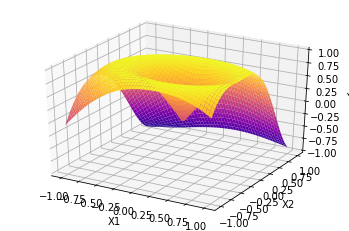

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [3]:
# %matplotlib tk

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X1, X2, Y, cmap='plasma')
# # ax.scatter(X1, X2, Y)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# plt.show()

### Using Neural Network

In [95]:
n_hidden = 10
optimizer = tnn.Adam()

net = tnn.AutoForm(new_layers=True)
layer1 = tnn.LinearLayer(2, n_hidden, optimizer=optimizer)
layer2 = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)

# def reposition_break_if_necessary(self:tnn.DoubleReluLinearLayer):
#     pass

In [96]:
%matplotlib tk

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    dx = net.backward(dy)
    
    net.update()
    
    if epoch%100 == 0:
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.4808450060851941


100 Error =  0.026121183887088017


200 Error =  0.01915719686405928


300 Error =  0.014917087392860334


400 Error =  0.009065063140822992


500 Error =  0.007088371162529995


600 Error =  0.006663193947982991


700 Error =  0.0065204195691992905


800 Error =  0.006229274615642184


900 Error =  0.0046224196348731055


1000 Error =  0.00411315137862972


1100 Error =  0.0037792514897229323


1200 Error =  0.0036114653624125794


1300 Error =  0.003548062496049412


1400 Error =  0.00352590471653612


1500 Error =  0.0035160642516503054


1600 Error =  0.0035126181979821167


1700 Error =  0.003511178820501754


1800 Error =  0.0035361951331298195


1900 Error =  0.0035094007976176167


2000 Error =  0.003508215227381664


2100 Error =  0.003508603849012213


2200 Error =  0.0035070959812348377


2300 Error =  0.0035074087748927702


2400 Error =  0.003510347557768233


2500 Error =  0.0036316958321810687


2600 Error =  0.0035140615914650455


2700 E

TclError: invalid command name "pyimage361"

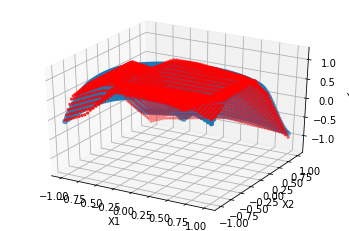

In [97]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [98]:
error

0.003252055480146109

## Convert this DoubleRelu Network into Relu Network

In [99]:
## backup
layer1c = copy.deepcopy(layer1)
layer2c = copy.deepcopy(layer2)

In [100]:
layer2c.weights.shape

(20, 1)

In [101]:
prev_yout = copy.deepcopy(yout)

#### Method 1: Removing negative activation and adding Linear Unit

In [102]:
optimizer = tnn.Adam(0.01)
layer1 = tnn.LinearLayer(2, n_hidden,
                         weights = copy.deepcopy(layer1c.weights),
                         bias = copy.deepcopy(layer1c.bias),
                         optimizer=optimizer)
layer2 = tnn.DoubleReluLinearLayer(n_hidden, 1,
                                   weights = copy.deepcopy(layer2c.weights),
                                   bias = copy.deepcopy(layer2c.bias),
                                   optimizer=optimizer)

linear = tnn.WeightsLayer(2, 1, optimizer=optimizer)
linear.weights *=0.

In [103]:
%matplotlib tk

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

fig = plt.figure()
ax = fig.gca(projection='3d')

layer2.weights[10:,0] = 0    
for epoch in range(100000):
    
    a1 = layer1.forward(xx)
    a20 = layer2.forward(a1)
    a21 = linear.forward(xx)
    yout = a20 + a21
    
    dy = yout - yy#prev_yout
    da20, da21 = dy, dy
    da1 = layer2.backward(da20)
    dx0 = layer1.backward(da1)
    dx1 = linear.backward(da21)
    dx = dx0 + dx1
    
    linear.update()
    layer2.update()
    layer2.weights[10:,0] = 0    
    
    if epoch%100 == 0:
        error = ((yout-yy)**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.6116216449177311


100 Error =  0.06042185660254187


200 Error =  0.03181252942162055


300 Error =  0.024278384585234562


400 Error =  0.02064566857090414


500 Error =  0.0182183984785888


600 Error =  0.016137395667025618


700 Error =  0.014239987842641053


800 Error =  0.01252414402094644


900 Error =  0.011003355805869234


1000 Error =  0.009682452633863066


1100 Error =  0.008556417842554674


1200 Error =  0.00761256389350219


1300 Error =  0.0068331245562639155


1400 Error =  0.006197652464878843


1500 Error =  0.005684986675590479


1600 Error =  0.005274730997953503


1700 Error =  0.004948199504083976


1800 Error =  0.004688889277543173


1900 Error =  0.0044828083221348375


2000 Error =  0.004318378241719771


2100 Error =  0.0041862266274121955


2200 Error =  0.004078928231473043


2300 Error =  0.003990618363362607


2400 Error =  0.003916783831290088


2500 Error =  0.0038539662117423297


2600 Error =  0.0037995395909853485


2700 Error =  0.0

TclError: invalid command name "pyimage372"

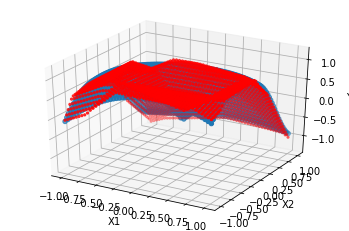

In [104]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [105]:
((yout-prev_yout)**2).mean()

5.830391151715417e-07

In [106]:
layer2.weights

array([[ 0.83361333],
       [-0.27377637],
       [-1.16364947],
       [-2.30989495],
       [-1.10543202],
       [-0.34701201],
       [-0.79619966],
       [-1.79452066],
       [ 1.57701347],
       [-0.77582113],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [107]:
layer2c.weights

array([[ 0.44631528],
       [ 0.56300781],
       [-0.23405192],
       [-0.77582696],
       [-0.4993483 ],
       [-0.51060936],
       [ 0.45992776],
       [-0.77767897],
       [ 1.16071752],
       [-0.73309291],
       [-0.38664821],
       [ 0.83796929],
       [ 0.93095011],
       [ 1.53223171],
       [ 0.60482204],
       [-0.16374166],
       [ 1.23974572],
       [ 1.01383339],
       [-0.41443043],
       [ 0.04304377]])

In [108]:
linear.weights

array([[ 0.21570426],
       [-2.21484577]])

#### Method 2: Removing negative activation (except one-if needed)

In [109]:
optimizer = tnn.Adam(0.01)
layer1 = tnn.LinearLayer(2, n_hidden,
                         weights = copy.deepcopy(layer1c.weights),
                         bias = copy.deepcopy(layer1c.bias),
                         optimizer=optimizer)
layer2 = tnn.DoubleReluLinearLayer(n_hidden, 1,
                                   weights = copy.deepcopy(layer2c.weights),
                                   bias = copy.deepcopy(layer2c.bias),
                                   optimizer=optimizer)

In [110]:
%matplotlib tk

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

fig = plt.figure()
ax = fig.gca(projection='3d')

layer2.weights[11:,0] = 0    
for epoch in range(100000):
    
    a1 = layer1.forward(xx)
    a20 = layer2.forward(a1)
    a21 = linear.forward(xx)
    yout = a20 + a21
    
    dy = yout - yy#prev_yout
    da20, da21 = dy, dy
    da1 = layer2.backward(da20)
    dx0 = layer1.backward(da1)
    dx1 = linear.backward(da21)
    dx = dx0 + dx1
    
    linear.update()
    layer2.update()
    layer2.weights[11:,0] = 0    
    
    if epoch%100 == 0:
        error = ((yout-yy)**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.7689134053272997


100 Error =  0.0578052243091623


200 Error =  0.027012992759173994


300 Error =  0.02009644655012228


400 Error =  0.016937872749591857


500 Error =  0.014604693047294464


600 Error =  0.012747773258623888


700 Error =  0.011270513321253641


800 Error =  0.010105852582608063


900 Error =  0.009192818701624542


1000 Error =  0.00847799025962402


1100 Error =  0.00791677466067843


1200 Error =  0.007472861505774995


1300 Error =  0.007117056192489351


1400 Error =  0.006826170149403714


1500 Error =  0.006582117698014462


1600 Error =  0.006371154977293511


1700 Error =  0.006183175666996281


1800 Error =  0.0060110273458873625


1900 Error =  0.0058498594250914315


2000 Error =  0.0056965341989176285


2100 Error =  0.005549129413115114


2200 Error =  0.005406545786484652


2300 Error =  0.005268216790187721


2400 Error =  0.005133906555142033


2500 Error =  0.005003576543319517


2600 Error =  0.00487730149036439


2700 Error =  0.00

TclError: invalid command name "pyimage383"

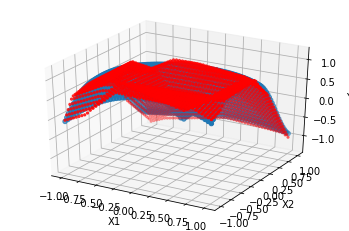

In [111]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [112]:
((yout-prev_yout)**2).mean()

5.898128519400951e-07

##### Removing all negative units

In [113]:
%matplotlib tk

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

fig = plt.figure()
ax = fig.gca(projection='3d')

layer2.weights[10:,0] = 0    
for epoch in range(100000):
    
    a1 = layer1.forward(xx)
    a20 = layer2.forward(a1)
    a21 = linear.forward(xx)
    yout = a20 + a21
    
    dy = yout - yy#prev_yout
    da20, da21 = dy, dy
    da1 = layer2.backward(da20)
    dx0 = layer1.backward(da1)
    dx1 = linear.backward(da21)
    dx = dx0 + dx1
    
    linear.update()
    layer2.update()
    layer2.weights[10:,0] = 0    
    
    if epoch%100 == 0:
        error = ((yout-yy)**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.18745073125303488


100 Error =  0.0034733418485086744


200 Error =  0.003397159768424247


300 Error =  0.0033612422517183944


400 Error =  0.0033391978127871452


500 Error =  0.0033241572243734884


600 Error =  0.0033128886359675654


700 Error =  0.0033038037628510273


800 Error =  0.0032961294631923678


900 Error =  0.0032894867104416897


1000 Error =  0.003283680248913933


1100 Error =  0.0032785977013686475


1200 Error =  0.003274163037720492


1300 Error =  0.0032703158452538046


1400 Error =  0.003267002393651432


1500 Error =  0.0032641719679898577


1600 Error =  0.0032617755473090698


1700 Error =  0.003259765542678757


1800 Error =  0.00325809601674432


1900 Error =  0.0032567231063101417


2000 Error =  0.0032556054994976238


2100 Error =  0.0032547048809790867


2200 Error =  0.00325398629323868


2300 Error =  0.003253418384305135


2400 Error =  0.0032529735289161714


2500 Error =  0.0032526278229468766


2600 Error =  0.0032523609610369355


TclError: invalid command name "pyimage396"

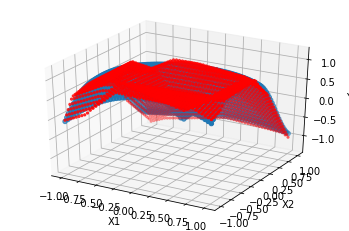

In [115]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [114]:
((yout-prev_yout)**2).mean()

5.630569782038396e-07